## Setup

In [1]:
# Web Scraping
import requests
import bs4
from urllib.parse import urljoin

# Data Manipulation
import numpy as np
import pandas as pd

from pandas import IndexSlice as idx

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [2]:
# Current latest report URL
REPORT_URL = 'https://proverbot9001.ucsd.edu/reports/2022-10-27T16d14d03-0700+6579b6846b7d8862fa80b21bdc7d45b0ad6ea048/'

# Get the report information and load into BS4
r = requests.get(REPORT_URL)
index_soup = bs4.BeautifulSoup(r.content)

In [3]:
# Grab each row in the table (without the header or the total)
table_rows = index_soup.table.find_all('tr')[1:]

# Associate each section with a URL for its data
section_urls = [row.a['href'] for row in table_rows]

# Turn each link into a soup
section_soups = [(href.removesuffix('index.html'), bs4.BeautifulSoup(requests.get(urljoin(REPORT_URL, href)).content)) for href in section_urls]

In [4]:
# Do the same, but for each file in each section now
section_rows = [(section, soup.table.find_all('tr')[1:-1]) for section, soup in section_soups]
file_urls = [(section, [row.a['href'] for row in rows]) for section, rows in section_rows]
file_soups = [[(section + href.removesuffix('.html'), bs4.BeautifulSoup(requests.get(urljoin(REPORT_URL, section + href)).content)) for href in hrefs] for section, hrefs in file_urls]

# Flatten
file_soups = sum(file_soups, [])

In [5]:
def process_file_soup(fname: str, soup: bs4.BeautifulSoup):
    # Grab all theorems and proofs
    relevant_elems = soup.select('button.collapsible, div.region')

    # Separate into alternating theorems and proofs, and check that each theorem (button) is followed by a theorem (div)
    thm_elems = relevant_elems[::2]
    prf_elems = relevant_elems[1::2]
    assert(all(x.name == 'button' for x in thm_elems))
    assert(all(x.name == 'div' for x in prf_elems))

    # Get all theorems, along with whether Proverbot succeeded
    theorems = [(thm.code.text, thm['class'][1]) for thm in thm_elems]
    theorems_df = pd.DataFrame(data=theorems, columns=['theorem', 'result'])

    # Get all proofs, and separate into the predicted proof and the original proof
    pred_orig_proofs = [(prf.find(class_='predicted').find_all('span'), prf.find(class_='original').find_all('span')) for prf in prf_elems]

    # For each such proof, separate out only the text and subgoals
    proofs = [([(x.text, x['data-subgoals']) for x in pred], [(x.text, x['data-subgoals']) for x in orig]) for pred, orig in pred_orig_proofs]

    # Create a DataFrame to hold these
    proofs_df = pd.DataFrame(proofs, columns=['pred', 'orig'])

    # Melt and reset to get theorem index and source as columns
    proofs_df = pd.melt(proofs_df, value_vars=['pred', 'orig'], var_name='source', ignore_index=False).reset_index(names='theorem')

    # Explode to turn the lists into rows, groupby cumulative count to give line numbers
    proofs_df = proofs_df.explode('value').reset_index(names='line')
    proofs_df['line'] = proofs_df.groupby('line').cumcount()

    # Combine theorem, source, and line number into our final multi-index
    proofs_df = proofs_df.set_index(['theorem', 'source', 'line']).sort_index()

    # Separate our combined value column into tactics and subgoals, then delete the redundant column
    proofs_df[['tactic', 'subgoals']] = pd.DataFrame(proofs_df['value'].to_list(), index=proofs_df.index)
    del proofs_df['value']

    # Return both with fname for easy unzipping
    return [(fname, theorems_df), (fname, proofs_df)]

In [6]:
full_data = [process_file_soup(fname, soup) for fname, soup in file_soups]

# Unzip our data (organized by proofs vs theorems instead of by filename primarily)
unzip_theorems, unzip_proofs = zip(*full_data)

theorem_df = pd.concat(dict(unzip_theorems))
theorem_df.index = theorem_df.index.set_names(['fname', 'index'])

# We also remove skipped theorems, as Proverbot pretends they do not exist
raw_proof_df = pd.concat(dict(unzip_proofs)).loc[theorem_df['result'] != 'skipped']
raw_proof_df.index = raw_proof_df.index.set_names({None: 'fname'})

In [7]:
theorem_df

theorem  \
fname                                              index                                                      
goedel/primRec                                     0      Lemma evalProjFuncInd :\n forall (n m : nat) (...   
                                                   1      Definition extEqualVectorGeneral (n m : nat) (...   
                                                   2      Definition extEqualVector n: forall m (l l' : ...   
                                                   3      Lemma extEqualVectorRefl :\n forall (n m : nat...   
                                                   4      Lemma extEqualOneParamList :\n forall (n m : n...   
...                                                                                                     ...   
UnifySL/Complete_Trivial                           0      Lemma general_completeness: strongly_complete ...   
UnifySL/PropositionalLogicZsDeepEmbeddedZsKripk... 0      Instance kiSM (M: Kmodel) {_: Kmodel_Monotonic...   
                                                   1      Instance kminSM (M: Kmodel): KripkeMinimumSema...   
                                                   2      Instance kpSM (M: Kmodel): KripkePropositional...   
UnifySL/PropositionalLanguage                      0      Definition formula_countable: forall {Sigma}, ...   

                                                           result  
fname                                              index           
goedel/primRec                                     0         okay  
                                                   1      skipped  
                                                   2      skipped  
                                                   3         okay  
                                                   4         okay  
...                                                           ...  
UnifySL/Complete_Trivial                           0          bad  
UnifySL/PropositionalLogicZsDeepEmbeddedZsKripk... 0         okay  
                                                   1      skipped  
                                                   2      skipped  
UnifySL/PropositionalLanguage                      0         okay  

[12186 rows x 2 columns]

In [8]:
raw_proof_df

tactic  \
fname                         theorem source line                                
goedel/primRec                0       orig   0                          Proof.   
                                             1                          intro.   
                                             2     induction n as [| n Hrecn].   
                                             3                         intros.   
                                             4             elim (lt_n_O _ p1).   
...                                                                        ...   
UnifySL/PropositionalLanguage 0       orig   57                    simpl in H.   
                                             58             inversion H; auto.   
                                             59                           Qed.   
                                      pred   0                          Proof.   
                                             1                       Admitted.   

                                                                                            subgoals  
fname                         theorem source line                                                     
goedel/primRec                0       orig   0     (("forall (n m : nat) (p1 p2 : lt m n),\neq (e...  
                                             1     (("forall (n m : nat) (p1 p2 : lt m n),\neq (e...  
                                             2     (("forall (m : nat) (p1 p2 : lt m n),\neq (eva...  
                                             3     (("forall (m : nat) (p1 p2 : lt m O),\neq (eva...  
                                             4     (("eq (evalProjFunc O m p1) (evalProjFunc O m ...  
...                                                                                              ...  
UnifySL/PropositionalLanguage 0       orig   57    (("eq a1 a2", ("H : eq\n  (existT (fun n : nat...  
                                             58    (("eq a1 a2", ("H : eq\n  (existT (fun n : nat...  
                                             59                                                   ()  
                                      pred   0     (("forall (Sigma : PropositionalVariables) (_ ...  
                                             1     (("forall (Sigma : PropositionalVariables) (_ ...  

[264423 rows x 2 columns]

### Data Cleaning

There are some proofs for which there is no predicted output at all. These show up as NaNs, so we remove them to allow more operations on the `DataFrame`.

In [9]:
raw_proof_df.loc[raw_proof_df['tactic'].isna()]

tactic  \
fname                                              theorem source line          
goedel/primRec                                     88      pred   0       NaN   
goedel/codeSubFormula                              35      pred   0       NaN   
goedel/folProp                                     31      pred   0       NaN   
goedel/cPair                                       1       pred   0       NaN   
                                                   17      pred   0       NaN   
...                                                                       ...   
dep-map/DepMapImplementation                       31      pred   0       NaN   
verdi/StatePacketPacketDecomposition               6       pred   0       NaN   
UnifySL/Intuitionistic                             26      pred   0       NaN   
UnifySL/Relation_ext                               6       pred   0       NaN   
UnifySL/MinimumLogicZsProofTheoryZsRewriteClassZdv 10      pred   0       NaN   

                                                                       subgoals  
fname                                              theorem source line           
goedel/primRec                                     88      pred   0        None  
goedel/codeSubFormula                              35      pred   0        None  
goedel/folProp                                     31      pred   0        None  
goedel/cPair                                       1       pred   0        None  
                                                   17      pred   0        None  
...                                                                         ...  
dep-map/DepMapImplementation                       31      pred   0        None  
verdi/StatePacketPacketDecomposition               6       pred   0        None  
UnifySL/Intuitionistic                             26      pred   0        None  
UnifySL/Relation_ext                               6       pred   0        None  
UnifySL/MinimumLogicZsProofTheoryZsRewriteClassZdv 10      pred   0        None  

[161 rows x 2 columns]

In [10]:
# With NAs removed, we can now interpret this DataFrame as all strings
str_proof_df = raw_proof_df.dropna(how='any').astype(str)

We will now remove the first and last line of each proof, since it contains no interesting information. This will also incidentally remove all `Proof. Admitted.` "proofs" created when Proverbot failed. 

There are some original proofs that do not start with some version of the `Proof` command. These are primarily due to the `Next Obligation.` command, so we will make sure not to remove the first line of these proofs.

In [11]:
missing_start = str_proof_df.loc[idx[:, :, :, 0], :].loc[~str_proof_df['tactic'].str.startswith('Proof')].index

str_proof_df.loc[missing_start]

tactic  \
fname                         theorem source line                                                      
goedel/primRec                49      orig   0                     apply (filter010IsPR _ succIsPR).   
                              51      orig   0                     apply (filter011IsPR _ plusIsPR).   
                              54      orig   0                     apply (filter010IsPR _ predIsPR).   
                              58      orig   0                                               intros.   
                              59      orig   0                                               intros.   
...                                                                                              ...   
UnifySL/Countable             0       orig   0            apply (FBuild_injection _ _ (fun _ => 0)).   
UnifySL/Bijection             8       orig   0     apply (Build_injection _ _ (fun a b => projT1 ...   
UnifySL/register_typeclass    0       orig   0                                               intros.   
UnifySL/MinimumLanguage       0       orig   0                                               intros.   
UnifySL/PropositionalLanguage 0       orig   0                                               intros.   

                                                                                            subgoals  
fname                         theorem source line                                                     
goedel/primRec                49      orig   0     (("isPR (S (S (S O))) (fun _ fn _ : nat => S f...  
                              51      orig   0     (("isPR (S (S (S O))) (fun _ fn b : nat => Ini...  
                              54      orig   0     (("isPR (S (S (S O))) (fun _ fn _ : nat => Ini...  
                              58      orig   0     (("forall (a b : nat) (_ : eq (ltBool a b) tru...  
                              59      orig   0     (("forall (a b : nat) (_ : eq (ltBool a b) fal...  
...                                                                                              ...  
UnifySL/Countable             0       orig   0                            (("Countable unit", ("")))  
UnifySL/Bijection             8       orig   0     (("injection (sigT A) (prod I B)", ("R : foral...  
UnifySL/register_typeclass    0       orig   0     (("forall (_ : RegisterClass unit O O) (_ : Re...  
UnifySL/MinimumLanguage       0       orig   0     (("forall (Var : Type) (_ : Countable Var), Co...  
UnifySL/PropositionalLanguage 0       orig   0     (("forall (Sigma : PropositionalVariables) (_ ...  

[1850 rows x 2 columns]

We will want to remove all aborted proofs, since they can't be reasonable compared. The other interesting ending is "Save", which seems to work the same as Qed but for goals, so it will just be removed as usual. There are also some proofs that contain only "Qed", and these will also have to be removed.

In [12]:
# Get the last line of each proof by looking at the max line number of each proof.
end_lines = str_proof_df.reset_index(level='line')['line'].groupby(level=['fname', 'theorem', 'source']).max()

# Convert this maximum back to an index (line)
end_index = end_lines.to_frame().reset_index().set_index(['fname', 'theorem', 'source', 'line']).sort_index().index

# Show all end tactics that aren't Qed, Defined, or Admitted
str_proof_df.loc[end_index].loc[idx[:, :, 'orig', :], :].loc[~str_proof_df['tactic'].isin(['Qed.', 'Admitted.', 'Defined.'])]

tactic  \
fname                                theorem source line                                  
UnifySL/ExtensionTactic              6       orig   2                            Abort.   
                                     7       orig   2                            Abort.   
UnifySL/OSAExamples                  22      orig   6                            Abort.   
                                     24      orig   4                            Abort.   
                                     38      orig   15    (*subst; reflexivity.*)\nQed.   
...                                                                                 ...   
demos/Demo                           4       orig   5                  Save Plus_assoc.   
                                     5       orig   1                  Save assoc_Plus.   
                                     6       orig   2                  Save size_assoc.   
verdi-raft/LeaderLogsContiguousProof 12      orig   2          (* and finish *)\n  Qed.   
weak-up-to/Relations                 12      orig   0             Proof fun x y H => H.   

                                                                                                   subgoals  
fname                                theorem source line                                                     
UnifySL/ExtensionTactic              6       orig   2     (("forall x : expr, provable (impp x x)", ("mi...  
                                     7       orig   2     (("forall (Phi : context) (x y z : expr),\nder...  
UnifySL/OSAExamples                  22      orig   6     (("ex\n  (fun n1 : natPlus =>\n   ex\n     (fu...  
                                     24      orig   4     (("ex\n  (fun m : natPlus =>\n   ex (fun n' : ...  
                                     38      orig   15                                                   ()  
...                                                                                                     ...  
demos/Demo                           4       orig   5                                                    ()  
                                     5       orig   1                                                    ()  
                                     6       orig   2                                                    ()  
verdi-raft/LeaderLogsContiguousProof 12      orig   2                                                    ()  
weak-up-to/Relations                 12      orig   0     (("incl R R", ("S,R,T : relation2 X Y","X,Y : ...  

[63 rows x 2 columns]

We now remove the first and last lines of every proof, except for the proofs requiring special treatment (the single line proofs and the ones that don't start with `Proof`). This does lose a small amount of information if there are proofs that contain `Proof with <tactic>.`, since it will become unknown what the `...` refers to, but this can always be recovered, and is very rare.

In [13]:
one_line_df = str_proof_df.loc[end_index[end_lines == 0]]

# Get rid of the irrelevant proofs
includes_abort = str_proof_df.loc[str_proof_df['tactic'].str.endswith('Abort.')].index
only_qed = one_line_df.loc[one_line_df['tactic'].str.endswith('Qed.')].index
filter_df = str_proof_df.loc[~str_proof_df.index.isin(includes_abort.union(only_qed).droplevel(('line', 'source')))]

# Get full proofs where the first line is not Proof or some variant thereof
missing_start_full = filter_df.loc[filter_df.index.isin(missing_start.droplevel('line'))].index

# Combine the 7 proofs without a "Proof" or other similar no-op tactic to start
# and the 8 proofs that are exactly 1 line.
unusual_index = missing_start_full.union(end_index[end_lines == 0])

# A DataFrame of all the proofs that don't need special treatment
normal_index = filter_df.index.difference(unusual_index)
normal_df = filter_df.loc[normal_index]

# Indexes the start and end of every "normal" proof
normal_start_index = normal_df.loc[idx[:, :, :, 0], :].index
normal_end_index = filter_df.index.intersection(end_index.difference(unusual_index))
to_remove_index = normal_start_index.union(normal_end_index)

# Remove the first and last lines, then decrement line count by one (zero indexing)
fixed_normal_df = normal_df.drop(index=to_remove_index).reset_index()
fixed_normal_df['line'] = fixed_normal_df['line'] - 1

# Since `Proof term.` is the same as `exact term. Qed.`, and we are removing `Qed.`, we can just replace `Proof` with `exact`.
one_line_df['tactic'] = one_line_df['tactic'].str.replace("Proof", "exact")

proof_df = pd.concat((
    one_line_df.loc[one_line_df.index.intersection(filter_df.index)],
    fixed_normal_df.set_index(['fname', 'theorem', 'source', 'line']),
    filter_df.loc[missing_start_full].drop(index=end_index.intersection(missing_start_full))
)).sort_index()
assert(proof_df.index.is_unique)

Finally, we create a couple of `DataFrames` that are ready to have analyses run on them.

In [14]:
# `proof_df` contains all proofs with any useful data; this is all original proofs, along with any predicted proof with something generated
# Contains all 508 + 133 original and predicted proofs, respectively

# Mirrored DataFrame; it contains a proof if and only if there is both an original proof and a predicted proof in proof_df
# Since there are no proofs in the predicted set but not in the original set, this means it contains only the proofs with generated output
# This makes comparisons more apples-to-apples, but may bias towards easier proofs
useful_thms = proof_df.loc[idx[:, :, 'pred', :], :].reset_index(['source', 'line']).index.unique()
mirror_proof_df = proof_df.loc[proof_df.index.isin(useful_thms)]

## Analysis

We verify on the next line that each line in our proofs contains exactly one tactic (or a bullet). There are some lines that certainly do more than one thing, however, since the `;` operator allows two or more tactics to be squished together. Whether these should be counted as separate lines is arguable, since the `;` operator also applies the second tactic on each subgoal generated, which is different than the usual behavior. Because it is difficult to estimate how many lines this tactical saves (since it could be anywhere from 1-100 lines depending on the number of subgoals), we leave it as is here, but note that it is one of the reasons for the shorter line counts.

In [15]:
a = proof_df.tactic.str.count('[-+*.{]$')
assert(len(a[a!=1]) == 0)

### Proof Line Counts

We now compare the line counts of the proofs in the dataset.

In [16]:
def calc_line_count(df: pd.DataFrame):
    # Length of each proof is the last line index, plus 1 due to 0 indexing
    return df.reset_index('line')['line'].groupby(['fname', 'theorem', 'source']).max() + 1

def plot_line_count(df: pd.DataFrame, ax = None, **kwargs):
    lens = calc_line_count(df).reset_index()
    # Normalize separately since the number of items in the two subsets are not the same
    norm_lens = pd.concat([lens[lens.source == 'orig'].value_counts(normalize=True), lens[lens.source == 'pred'].value_counts(normalize=True)]).reset_index()

    ax = sns.histplot(data=norm_lens, x='line', weights='proportion', hue='source', discrete=True, ax=ax)
    ax.set(xlabel='Line Count', ylabel='Proportion', **kwargs);

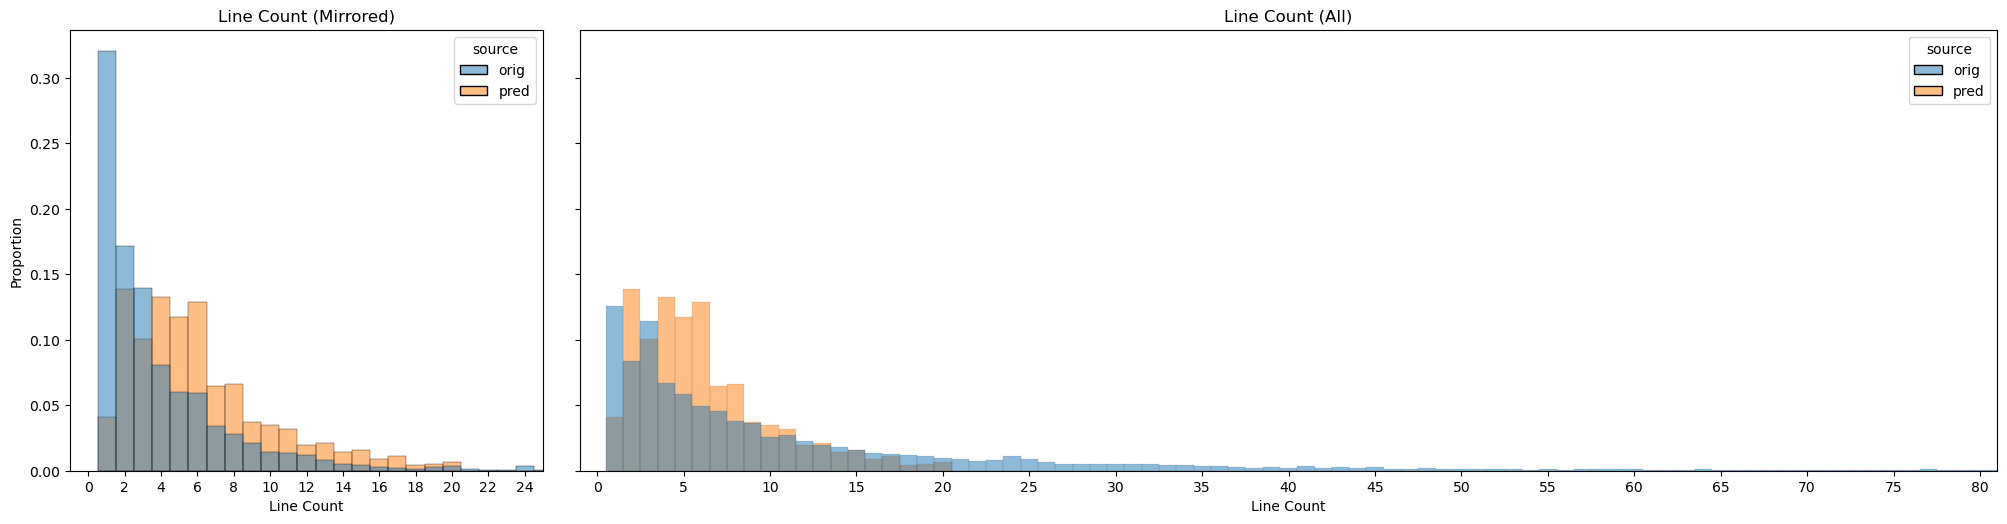

In [17]:
# Remove the 300 line proof so that we can see what is happening
acceptable = proof_df.index #.difference(proof_df.loc[idx['Selectionproof', 56, 'orig', :], :].index)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20, 5), width_ratios=[1, 3])
fig.tight_layout()

plot_line_count(mirror_proof_df,          ax=axs[0], xticks=range(0, 25, 2), title='Line Count (Mirrored)', xlim=(-1, 25))
plot_line_count(proof_df.loc[acceptable], ax=axs[1], xticks=range(0, 81, 5), title='Line Count (All)',      xlim=(-1, 81))

In [18]:
# Average of solutions by Proverbot:
calc_line_count(mirror_proof_df.loc[idx[:, :, 'pred'], :]).agg(['mean', 'median', 'min', 'max'])

mean       6.108889
median     5.000000
min        1.000000
max       20.000000
Name: line, dtype: float64

In [19]:
# Average of original proofs also solved by Proverbot:
calc_line_count(mirror_proof_df.loc[idx[:, :, 'orig'], :]).agg(['mean', 'median', 'min', 'max'])

mean        4.200444
median      3.000000
min         1.000000
max       129.000000
Name: line, dtype: float64

In [20]:
# Average of all original proofs:
calc_line_count(proof_df.loc[idx[:, :, 'orig'], :]).agg(['mean', 'median', 'min', 'max'])

mean        17.383729
median       7.000000
min          1.000000
max       1599.000000
Name: line, dtype: float64

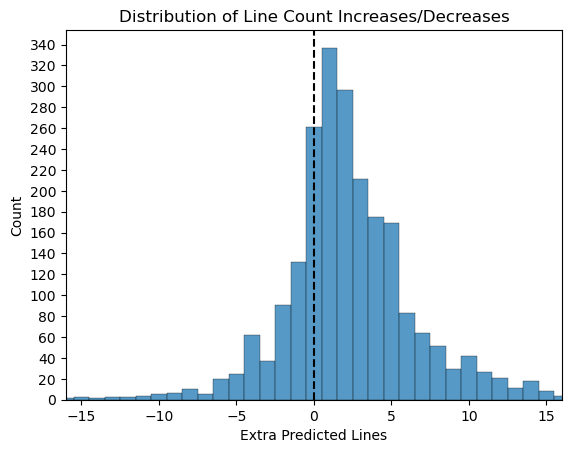

In [21]:
lens = calc_line_count(mirror_proof_df)
ax = sns.histplot(lens.loc[idx[:, :, 'pred']] - lens.loc[idx[:, :, 'orig']], discrete=True)
ax.set(xlim=[-16, 16], yticks=range(0, 341, 20), xlabel="Extra Predicted Lines", title="Distribution of Line Count Increases/Decreases")
ax.axvline(0, color='k', linestyle='--');

In [22]:
(lens.loc[idx[:, :, 'pred']] - lens.loc[idx[:, :, 'orig']]).agg(['mean', 'median'])

mean      1.908444
median    2.000000
Name: line, dtype: float64

Indeed, we see that most Proverbot proofs use around 2 extra lines over the original, although a small selection do better than the original (negative values).

### Tactic Frequency

In [23]:
# Strip comments
no_comments = proof_df.tactic.str.replace(r'\(\*.*?\*\)', '', regex=True)
# Strip goal selectors
no_selectors = no_comments.str.replace(r'^\d+:', '', regex=True)
# Delete Ltac declarations
no_ltac = no_selectors.drop(index=no_selectors[no_selectors.str.startswith('Ltac')].index)

# Get all tactics, including those combined with ;
tactic_invocations = no_ltac.str.split(';').explode().str.strip()
# Remove subgoals handled with [ | ] syntax, as this is so rare it is not worth handling specially.
no_brackets = tactic_invocations.drop(index=tactic_invocations[tactic_invocations.str.startswith('[')].index)

tactics = no_brackets.str.split(r'[ .()=]', n=1, expand=True)[0]

tactics

fname                   theorem  source  line
PolTac/NAux             0        orig    0            intros
                                         1              case
                                         2              case
                                         3            unfold
                                         4             simpl
                                                    ...     
zorns-lemma/ZornsLemma  8        orig    94          rewrite
                                         95      constructor
                                         96              now
                                         97               **
                                         98              now
Name: 0, Length: 262838, dtype: object

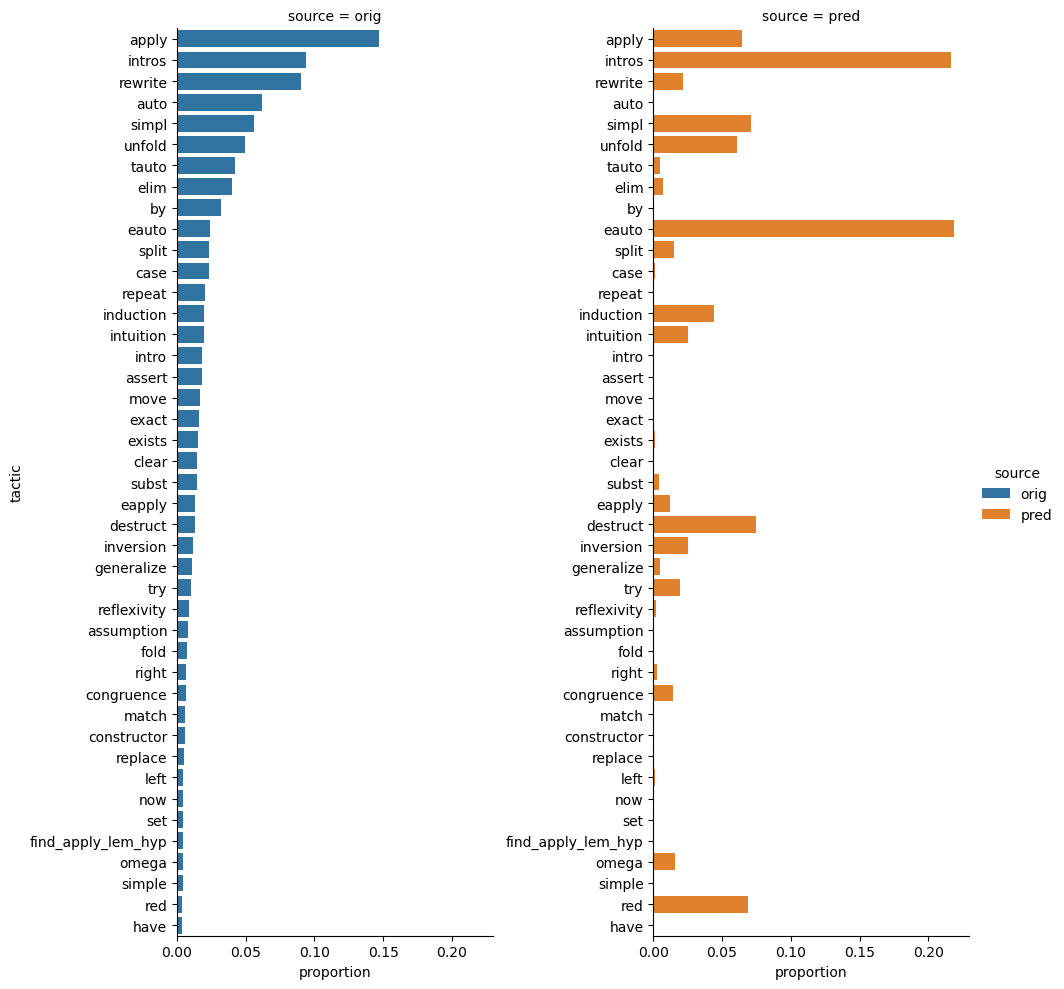

In [24]:
docs = {
    ' '.join(proof_df.loc[idx[:, :, 'orig', :], :].tactic.to_list()),
    ' '.join(proof_df.loc[idx[:, :, 'pred', :], :].tactic.to_list()),
}
vocab = tactics[idx[:, :, 'orig', :]].value_counts()[:50].index

count_vectors = CountVectorizer(vocabulary=vocab, lowercase=False).fit_transform(raw_documents=docs).todense()
counts = pd.DataFrame(np.vstack((vocab, count_vectors)).T, columns=['tactic', 'orig', 'pred'])
counts['total'] = counts['orig'] + counts['pred']
counts = counts.sort_values(by='orig', ascending=False).reset_index()
counts = counts.drop(counts[counts.total == 0].index)

proportions = counts.copy()
proportions['orig'] /= proportions['orig'].sum()
proportions['pred'] /= proportions['pred'].sum()

melted_prop = proportions.melt(id_vars='tactic', value_vars=['orig', 'pred'], var_name='source', value_name='proportion')

sns.catplot(data=melted_prop, y='tactic', x='proportion', col='source', hue='source', kind='bar', height=10, aspect=0.5, sharey=False);

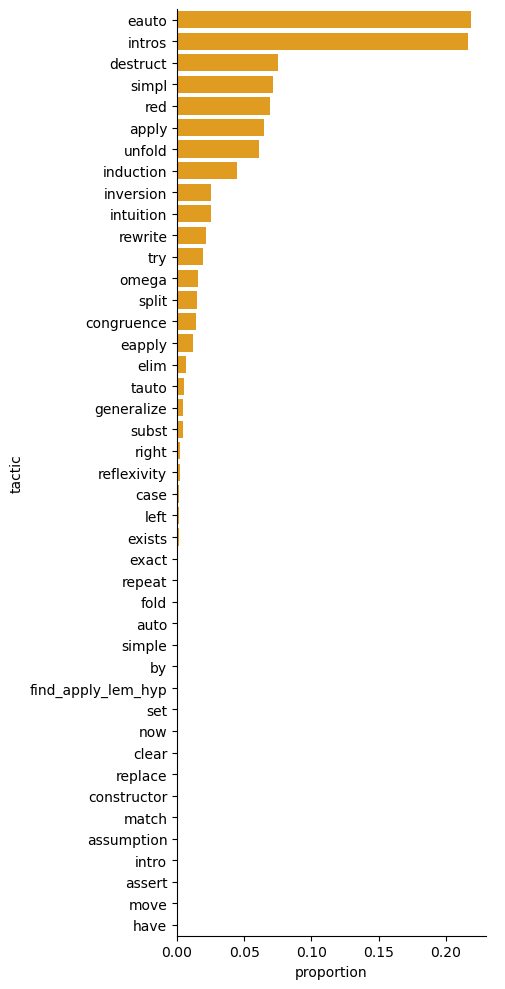

In [25]:
sns.catplot(data=melted_prop[melted_prop['source'] == 'pred'].sort_values('proportion', ascending=False), 
            y='tactic', x='proportion', color='orange', kind='bar', height=10, aspect=0.5, sharey=False);